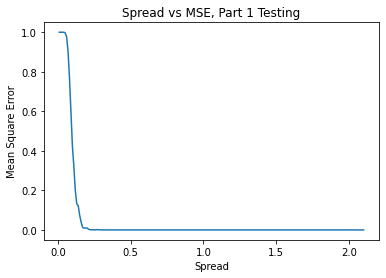

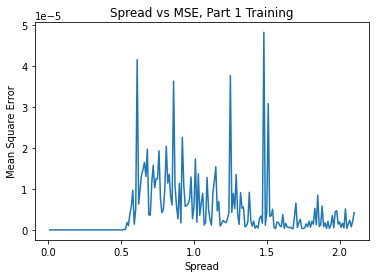

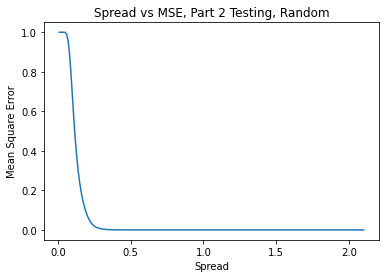

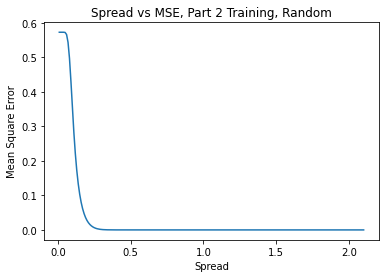

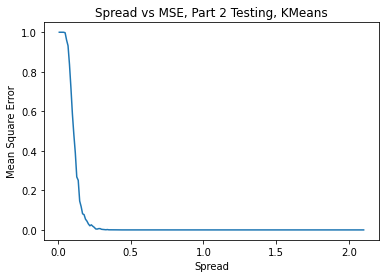

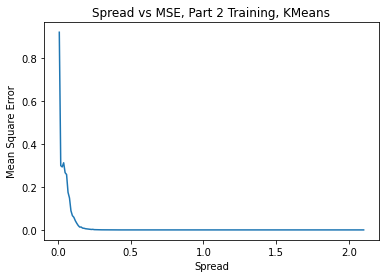

In [1]:
import random
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

class RBFNN:

    def __init__(self,seed, layers, centre_selection,sigma=1):
        self.training_data, self.training_targets, self.testing_data, self.testing_targets = self.generateTrainingPoints(seed)
        self.seed = seed
        self.spread = sigma
        self.layers = layers
        self.centre_selection = centre_selection
        self.weights = None

    def generateTrainingPoints(self,seed):
        random.seed(seed)
        inputs = np.empty((441, 2))
        targets = np.empty((441,2))
        count = 0

        for i in range (21): #generate points as per the question
            for j in range(21):
                x = -2 + 0.2*i
                y = -2 + 0.2*j
                sum = x**2 + y**2
                if sum <= 1:
                    inputs[count] = [x,y]
                    targets[count] = [1,0] #one hot encoded
                else:
                    inputs[count] = [x,y]
                    targets[count] = [0,1]
                count += 1

        combined = np.concatenate((inputs, targets),axis=1)
        np.take(combined, np.random.permutation(combined.shape[0]), axis=0, out=combined) #randomise
        training_data = combined[:351,:-2] #split training and testing
        training_targets = combined[:351, -2:]
        testing_data = combined[351:, :-2]
        testing_targets = combined[351:,-2:] #splitting data into train and test sets


        return training_data, training_targets, testing_data, testing_targets

    def propogateInputs(self, training=True, train_test=False):
        if training:
            if self.centre_selection == "all": #if for first part of the question
                self.centres = self.training_data
            else:
                self.centres = self.find_centres() #else find centres by random or kmeans
            self.hiddenLayer = np.empty((self.training_data.shape[0], self.layers[1]))
            for i in range (self.training_data.shape[0]):
                datatemp = np.tile(self.training_data[i], (self.layers[1], 1)) #reshape each input for propogation to all neurons
                self.hiddenLayer[i] = self.gauss(datatemp, self.centres, self.spread)
        elif not training and not train_test: #for test propogation
            self.hiddenLayer = np.empty((self.testing_data.shape[0], self.layers[1]))
            for i in range(self.testing_data.shape[0]):
                datatemp = np.tile(self.testing_data[i], (self.layers[1],1))
                self.hiddenLayer[i] = self.gauss(datatemp, self.centres, self.spread)
        else: #for train propogation (for training accuracy)
            self.hiddenLayer = np.empty((self.training_data.shape[0], self.layers[1]))
            for i in range(self.training_data.shape[0]):
                datatemp = np.tile(self.training_data[i], (self.layers[1],1))
                self.hiddenLayer[i] = self.gauss(datatemp, self.centres, self.spread)



    def calculateWeights(self):
        pseudoInv = np.linalg.pinv(self.hiddenLayer)
        self.weights = pseudoInv.dot(self.training_targets) #closed loop calc for weights (training)

    def meanSquareError(self, targets, outputs):
        return np.square(np.sum(targets-outputs, axis=1)).mean(axis=0)

    def accuracy(self, target, output):
        correct = 0
        for i in range(len(target)):
            if np.round(np.sum(np.abs(target[i]-output[i]))) == 0:
                correct += 1
        return correct / float(len(target)) * 100.0


    def gauss(self,x, v, sigma):
        val = np.exp(-np.linalg.norm(x-v, 2, axis=1)**2/(2*sigma**2))
        return val #gaussian function

    def find_centres(self):
        if self.centre_selection == "random": #random centre selection
            np.random.seed(self.seed)
            index = np.random.choice(self.training_data.shape[0], self.layers[1], replace=False)
            return self.training_data[index]
        elif self.centre_selection == "kmeans": #kmeans selection
            kmeans = KMeans(self.layers[1], random_state=self.seed).fit(self.training_data)
            return kmeans.cluster_centers_

    def setup(self):
        self.propogateInputs()
        self.calculateWeights()

    def calculateOutputs_Error(self):
        self.propogateInputs(training=False)
        outputs = self.hiddenLayer.dot(self.weights)
        error = self.meanSquareError(self.testing_targets, outputs)
        #error = self.accuracy(self.testing_targets, outputs)
        return outputs, error

    def calculateTraining_Error(self):
        self.propogateInputs(training=False, train_test=True)
        outputs = self.hiddenLayer.dot(self.weights)
        error = self.meanSquareError(self.training_targets, outputs)
        return outputs, error


errors = {} #setup errors for plotting
errors_training = {}
errors1 = {}
errors1_training = {}
errors2 = {}
errors2_training = {}

for std in np.arange(0.01,2.1, 0.01): #loop through all spreads - part1
    rbf = RBFNN(25, [441,351,2], "all", std)
    rbf.setup()
    outputs, error = rbf.calculateOutputs_Error() #store testing outputs and error
    output_train, error_train = rbf.calculateTraining_Error() #store training outputs and error
    errors[std] = error
    errors_training[std] = error_train


for std in np.arange(0.01, 2.1, 0.01):
    rbf2 = RBFNN(25, [441,150,2], "random", std) #random centre selection, part 2 of question
    rbf2.setup()
    outputs2, error2 = rbf2.calculateOutputs_Error()
    output2_train, error2_train = rbf2.calculateTraining_Error()
    errors1[std] = error2
    errors1_training[std] = error2_train


for std in np.arange(0.01, 2.1, 0.01):
    rbf3 = RBFNN(25, [441,150,2], "kmeans", std) #kmeans centre selection, part 2 of question
    rbf3.setup()
    outputs3, error3 = rbf3.calculateOutputs_Error()
    output3_train, error3_train = rbf3.calculateTraining_Error()
    errors2[std] = error3
    errors2_training[std] = error3_train

titles = ["Spread vs MSE, Part 1 Testing",
          "Spread vs MSE, Part 1 Training",
          "Spread vs MSE, Part 2 Testing, Random",
          "Spread vs MSE, Part 2 Training, Random",
          "Spread vs MSE, Part 2 Testing, KMeans",
          "Spread vs MSE, Part 2 Training, KMeans"
          ]

errors_array = [errors, errors_training, errors1, errors1_training, errors2, errors2_training]

for i in range(len(errors_array)):
    lists = sorted(errors_array[i].items())
    x, y = zip(*lists)
    plt.plot(x,y)
    plt.xlabel("Spread")
    plt.ylabel("Mean Square Error")
    plt.title(titles[i])
    plt.show()

